# Read and filter data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-statements" data-toc-modified-id="Import-statements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import statements</a></span><ul class="toc-item"><li><span><a href="#Import-scanpy" data-toc-modified-id="Import-scanpy-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import scanpy</a></span></li><li><span><a href="#Import-my-utility-functions-and-import-statements-from-github" data-toc-modified-id="Import-my-utility-functions-and-import-statements-from-github-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import my utility functions and import statements from github</a></span></li></ul></li><li><span><a href="#Load-inDrops-data,-post-star-solo-indrops" data-toc-modified-id="Load-inDrops-data,-post-star-solo-indrops-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load inDrops data, post star-solo-indrops</a></span></li><li><span><a href="#Filter-on-total-counts-and-fraction-mito" data-toc-modified-id="Filter-on-total-counts-and-fraction-mito-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter on total counts and fraction mito</a></span><ul class="toc-item"><li><span><a href="#Select-thresholds" data-toc-modified-id="Select-thresholds-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Select thresholds</a></span></li><li><span><a href="#Apply-the-thesholds-(filter-data)" data-toc-modified-id="Apply-the-thesholds-(filter-data)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Apply the thesholds (filter data)</a></span></li></ul></li><li><span><a href="#Record-in-adata.obs-any-extra-per-cell-information-if-available" data-toc-modified-id="Record-in-adata.obs-any-extra-per-cell-information-if-available-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Record in adata.obs any extra per-cell information if available</a></span><ul class="toc-item"><li><span><a href="#Categorical" data-toc-modified-id="Categorical-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Categorical</a></span></li><li><span><a href="#Numerical" data-toc-modified-id="Numerical-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Numerical</a></span></li></ul></li></ul></div>

## Import statements

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


### Import my utility functions and import statements from github

In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_210525_14h42/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params 
import rz_utility_spring as srz

python version: 3.6.7


## Load inDrops data, post star-solo-indrops

In [5]:
!ls ../counts/

Monocyte_1_ix2_S1 Monocyte_2_ix5_S3 Monocyte_3_ix7_S5 Monocyte_3_ix9_S7
Monocyte_1_ix3_S2 Monocyte_2_ix6_S4 Monocyte_3_ix8_S6


In [6]:
# list of library names
libs = sorted(set([i.split('/')[-1] for i in glob.glob('../counts/*')]))
libs

['Monocyte_1_ix2_S1',
 'Monocyte_1_ix3_S2',
 'Monocyte_2_ix5_S3',
 'Monocyte_2_ix6_S4',
 'Monocyte_3_ix7_S5',
 'Monocyte_3_ix8_S6',
 'Monocyte_3_ix9_S7']

In [7]:
# libraries to skip:
toskip = []

print(len(libs))
libs = [i for i in libs if i not in toskip]
print(len(libs))

7
7


In [8]:
# empty list for storing AnnData files
lad = []

# path to counts, genes, barcodes
p = "../counts"

start = time.time()
for lib in libs:
    
    adata = sc.read_mtx(p+'/'+lib+'/matrix.mtx')
    adata = adata.T
    print(lib+' shape:',adata.shape)
    
    # barcodes
    adata.obs['barcode'] = np.loadtxt(p+'/'+lib+'/barcodes.tsv',dtype=str)
    
    # features (essentially gene names)
    feat = pd.read_csv(p+'/'+lib+'/features.tsv',sep='\t',header=None)
    feat.columns = ['ensembl','gene','type']
    adata.var = feat
    
    # add gene names to adata.var_names
    adata.var_names = adata.var['gene']
    print(len(adata.var_names),len(set(adata.var_names)))
    
    
    # what are the non-unique genes? Slow-ish
    seen = []
    duplicated = []
    for i in adata.var_names:
        if i in seen:
            duplicated.append(i)
        seen.append(i)
        
    print("\nList of genes that are repeated, and the number of duplications")
    print(pd.Series(Counter(duplicated)))
    print('\n')
    
    # make unique
    adata.var_names_make_unique()
    print(len(adata.var_names),len(set(adata.var_names)))

    adata.obs['library'] = lib
    lad.append(adata)
    print(lib,'done')
    print('='*30)
    print()
    
print("%.1f min."%((time.time()-start)/60.))

Monocyte_1_ix2_S1 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_1_ix2_S1 done

Monocyte_1_ix3_S2 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_1_ix3_S2 done

Monocyte_2_ix5_S3 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_2_ix5_S3 done

Monocyte_2_ix6_S4 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_2_ix6_S4 done

Monocyte_3_ix7_S5 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_3_ix7_S5 done

Monocyte_3_ix8_S6 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_3_ix8_S6 done

Monocyte_3_ix9_S7 shape: (147456, 36601)


AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36601 36591

List of genes that are repeated, and the number of duplications
TBCE              1
LINC01238         1
CYB561D2          1
MATR3             1
LINC01505         1
HSPA14            1
GOLGA8M           1
GGT1              1
ARMCX5-GPRASP2    1
TMSB15B           1
dtype: int64


36601 36601
Monocyte_3_ix9_S7 done

4.1 min.


In [9]:
# gene names must be the same but double-check
v0 = lad[0].var_names
print(np.prod([np.prod(v0==i.var_names) for i in lad]).astype(bool))

# also check that gene names are unique:
print(len(v0)==len(set(v0)))

True
True


In [10]:
# let's concatenate "manually", for a large number of AnnData objects
# AnnData.concatenate did not work well for me

Xcat = scipy.sparse.vstack([i.X for i in lad])
obscat = pd.concat([i.obs for i in lad])
varnames = lad[0].var_names


adata = sc.AnnData(Xcat)
adata.obs = obscat
adata.var_names = varnames

# index
adata.obs_names = np.arange(adata.shape[0]).astype(str)


print(adata.shape)

(1032192, 36601)


## Filter on total counts and fraction mito

In [11]:
mitogenes = [i for i in adata.var_names if i.startswith('MT-')]
print(len(mitogenes))
mitogenes

13


['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

In [12]:
# get total counts and mito fraction
# in principle, one could also use pp.calculate_qc_metrics, maybe to study at some point
# I am sticking to 

# total counts
adata.obs['total_counts'] = adata.X.sum(axis=1)

# remove barcodes with veeery few counts, e.g. 10
cmask = adata.obs['total_counts'].values>10
print(adata.shape)
adata = adata[cmask]
print(adata.shape)

(1032192, 36601)
(1013570, 36601)


In [13]:
# mito percentage
mitomask = np.in1d(adata.var_names,mitogenes)
adata.obs['pct_counts_mito'] = np.array(adata.X[:,mitomask].sum(axis=1)).T[0]/adata.obs['total_counts'].values*100.

Trying to set attribute `.obs` of view, making a copy.


### Select thresholds

In [14]:
libcol = 'library' # column of obs to use

# just a hack to faster fill-in thresholds used, they are set by eye
libs = adata.obs[libcol].unique()

#for entering threshold, copy/paste the output of this cell below
print("ts_dict = {") #for "threshold dictionary"
for lib in libs:
    print('"%s":(900,101), #(min_nr_genes,max_pct_mito)'%lib)
print('}')

ts_dict = {
"Monocyte_1_ix2_S1":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_1_ix3_S2":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_2_ix5_S3":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_2_ix6_S4":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_3_ix7_S5":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_3_ix8_S6":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_3_ix9_S7":(900,101), #(min_nr_genes,max_pct_mito)
}


In [15]:
# copy and edit output of previous cell
# first run with any thresholds, then adjust based on the distribution of barcodes

ts_dict = {
"Monocyte_1_ix2_S1":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_1_ix3_S2":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_2_ix5_S3":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_2_ix6_S4":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_3_ix7_S5":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_3_ix8_S6":(900,101), #(min_nr_genes,max_pct_mito)
"Monocyte_3_ix9_S7":(900,101), #(min_nr_genes,max_pct_mito)
}

32415


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


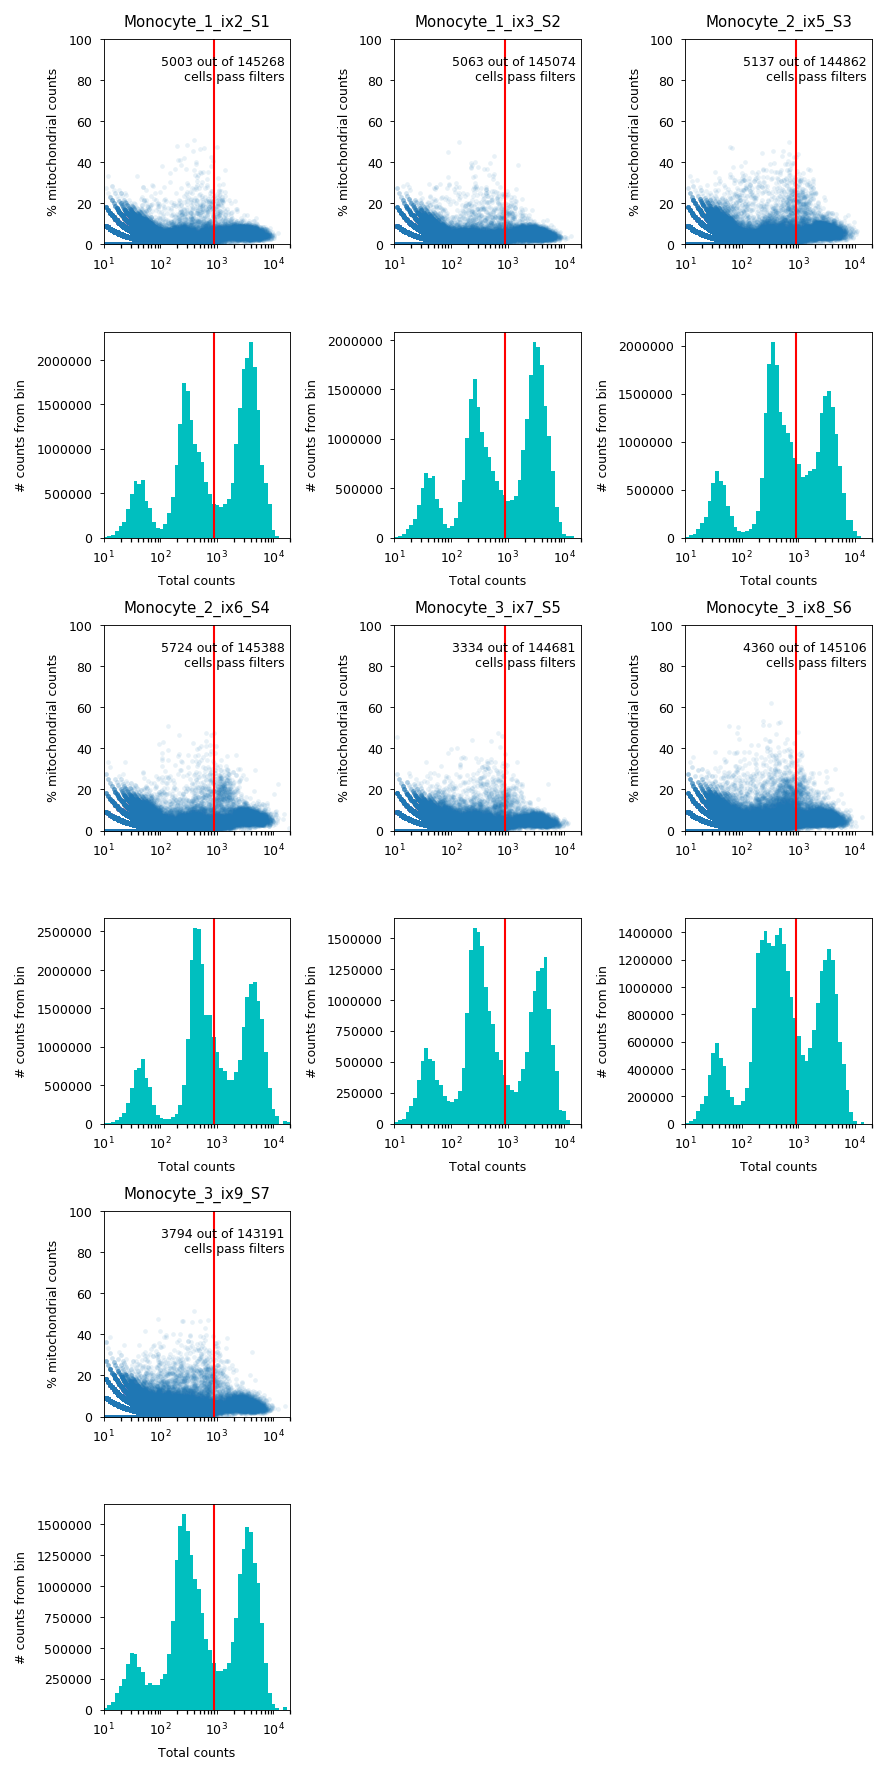

In [16]:
import math
pass_filters = []

#plot mito histograms
nr_rows = math.ceil(len(libs)/3.)

fig,gs = rz.startfig(w=15,h=nr_rows*10,rows=nr_rows*2,columns=3,return_first_ax=False)
#startfig - a custom function by Rapo

#best way I could think of to get all the coordinates of the my subplots
coords = np.argwhere(np.zeros([nr_rows,3]) == 0)

# control total count range to expect
xmin = 10
xmax = 20000

!mkdir -p outputs

for c,lib in zip(coords,libs):
    
    a = fig.add_subplot(gs[c[0]*2,c[1]])
    a1 = fig.add_subplot(gs[c[0]*2+1,c[1]])

    mask = adata.obs[libcol] == lib
    x = adata.obs.loc[mask,'total_counts']
    y = adata.obs.loc[mask,'pct_counts_mito']
    
    #scatter
    a.scatter(x,y,lw=0,s=5,alpha=0.1,rasterized=True)
    a.set_xscale('log')
    a.set_xlim(xmin,xmax)
    a.set_ylim(0,100)
    a.set_ylabel('% mitochondrial counts')
    a.set_title(lib)
    
    #plot threshold in scatter
    ts = ts_dict[lib]
    a.plot((ts[0],ts[0]),(a.get_ylim()[0],ts[1]),lw=1,color='r')
    a.plot((ts[0],a.get_xlim()[1]),(ts[1],ts[1]),lw=1,color='r')
    pass_ts = (adata.obs.loc[mask,'total_counts']>=ts[0])&(adata.obs.loc[mask,'pct_counts_mito']<ts[1])
    cells_pass = pass_ts.sum()
    cells_all = len(pass_ts)
    a.text(a.get_xlim()[1]*0.8,a.get_ylim()[1]*0.8,
           "%d out of %d\ncells pass filters"%(cells_pass,cells_all),
           ha='right')
    pass_filters+=(list(pass_ts.values))
    
    # histogram
    bins=np.logspace(np.log10(xmin),np.log10(xmax),51)
    hs, bins,patches = plt.hist(x,bins=bins)
    
    #plot barchart
    lefts = bins[:-1]
    rights = bins[1:]
    a1.bar(x = lefts,width = rights-lefts,height = hs*rights,
          align='edge',
          lw=0.,color = 'c')
    a1.set_xscale('log');
    a1.set_xlim(xmin,xmax)
    # threshold:
    a1.plot((ts[0],ts[0]),(a1.get_ylim()[0],a1.set_ylim()[1]),lw=1,color='r')
    a1.set_xlabel('Total counts')
    
    a1.set_ylabel('# counts from bin')
           

print(sum(pass_filters))
gs.tight_layout(fig)
!mkdir -p outputs
plt.savefig('outputs/mito_pct_vs_total_counts.pdf',dpi=300)

### Apply the thesholds (filter data)

In [17]:
cmask = np.repeat(True,adata.shape[0])

for key,value in ts_dict.items():
    m1 = (adata.obs[libcol] == key).values
    tmp = adata.obs[m1]
    m2 = (tmp['total_counts']>=value[0]).values
    m3 = (tmp['pct_counts_mito']<value[1]).values
    cmask[m1] = m2&m3
    
print(cmask.sum(),cmask.shape)

32415 (1013570,)


In [18]:
print(adata.shape)
adata = adata[cmask]
print(adata.shape)

(1013570, 36601)
(32415, 36601)


## Record in adata.obs any extra per-cell information if available

In [19]:
adata.obs['library'].unique()

array(['Monocyte_1_ix2_S1', 'Monocyte_1_ix3_S2', 'Monocyte_2_ix5_S3',
       'Monocyte_2_ix6_S4', 'Monocyte_3_ix7_S5', 'Monocyte_3_ix8_S6',
       'Monocyte_3_ix9_S7'], dtype=object)

In [22]:
#overwrite to hide the label
adata.obs['library'] = [i[9:] for i in adata.obs['library']]

Trying to set attribute `.obs` of view, making a copy.


### Categorical

In [23]:
adata.obs['condition'] = [i[:-7] for i in adata.obs['library']]
adata.obs['condition'].unique()

array(['1', '2', '3'], dtype=object)

In [24]:
adata.obs.head()

,barcode,library,total_counts,pct_counts_mito,condition
82,AACAGCGAATACCGCA,1_ix2_S1,2560.0,6.562500,1
121,AACAGCGACAGAGATG,1_ix2_S1,1383.0,4.410701,1
130,AACAGCGACATAGCTG,1_ix2_S1,913.0,6.681271,1
132,AACAGCGACATCGTCT,1_ix2_S1,3974.0,2.717665,1
174,AACAGCGACGTCTCAT,1_ix2_S1,1988.0,2.615694,1


In [25]:
# for quick selection of cells above a certain total count threshold
ts = [1000,1500,2000]
for i in ts:
    adata.obs['more_than_%d_total_counts'%i] = (adata.obs['total_counts']>i).astype(str)

In [26]:
adata.obs.head()

,barcode,library,total_counts,pct_counts_mito,condition,more_than_1000_total_counts,more_than_1500_total_counts,more_than_2000_total_counts
82,AACAGCGAATACCGCA,1_ix2_S1,2560.0,6.562500,1,True,True,True
121,AACAGCGACAGAGATG,1_ix2_S1,1383.0,4.410701,1,True,False,False
130,AACAGCGACATAGCTG,1_ix2_S1,913.0,6.681271,1,False,False,False
132,AACAGCGACATCGTCT,1_ix2_S1,3974.0,2.717665,1,True,True,True
174,AACAGCGACGTCTCAT,1_ix2_S1,1988.0,2.615694,1,True,True,False


### Numerical

In [27]:
# number of genes detected
adata.obs['genes_detected'] = np.array((adata.X>0).sum(axis=1)).T[0]

In [28]:
# directory
!mkdir -p backups

# write the entire adata.object
start = time.time()
fname1 = 'backups/mito_total_counts_filt_raw_%dx%d_%s.h5ad'%(adata.shape[0],adata.shape[1],rz.now())
print(fname1)
adata.write(fname1)
print(time.time()-start)

# write the pandas dataframe under adata.obs as a separate file
# this part of the AnnData object changes most, is relatively small, and backups are nice
meta = adata.obs
fname2 = 'backups/obs_info_%dx%d_%s'%(meta.shape[0],meta.shape[1],rz.now())
print(fname2)
rz.save_df(meta,fname2)
print(time.time()-start)

backups/mito_total_counts_filt_raw_32415x36601_210622_20h17.h5ad


... storing 'barcode' as categorical
... storing 'library' as categorical
... storing 'condition' as categorical
... storing 'more_than_1000_total_counts' as categorical
... storing 'more_than_1500_total_counts' as categorical
... storing 'more_than_2000_total_counts' as categorical


0.8931169509887695
backups/obs_info_32415x9_210622_20h17
1.0973577499389648


# Have a look at some stats

In [29]:
adata.obs.head(5)

,barcode,library,total_counts,pct_counts_mito,condition,more_than_1000_total_counts,more_than_1500_total_counts,more_than_2000_total_counts,genes_detected
82,AACAGCGAATACCGCA,1_ix2_S1,2560.0,6.562500,1,True,True,True,947
121,AACAGCGACAGAGATG,1_ix2_S1,1383.0,4.410701,1,True,False,False,595
130,AACAGCGACATAGCTG,1_ix2_S1,913.0,6.681271,1,False,False,False,502
132,AACAGCGACATCGTCT,1_ix2_S1,3974.0,2.717665,1,True,True,True,1438
174,AACAGCGACGTCTCAT,1_ix2_S1,1988.0,2.615694,1,True,True,False,827


In [30]:
adata.obs.groupby('library').count().iloc[:,0]

library
1_ix2_S1    5003
1_ix3_S2    5063
2_ix5_S3    5137
2_ix6_S4    5724
3_ix7_S5    3334
3_ix8_S6    4360
3_ix9_S7    3794
Name: barcode, dtype: int64

In [31]:
adata.obs.groupby('condition').count().iloc[:,0]

condition
1    10066
2    10861
3    11488
Name: barcode, dtype: int64

In [32]:
adata.obs.groupby('library').median()['total_counts']

library
1_ix2_S1    2763.0
1_ix3_S2    2499.0
2_ix5_S3    1960.0
2_ix6_S4    2023.5
3_ix7_S5    2620.0
3_ix8_S6    2023.0
3_ix9_S7    2585.5
Name: total_counts, dtype: float32

In [33]:
adata.obs.groupby('library').median()['genes_detected']

library
1_ix2_S1    1061.0
1_ix3_S2     995.0
2_ix5_S3     877.0
2_ix6_S4     871.0
3_ix7_S5    1043.5
3_ix8_S6     769.0
3_ix9_S7     953.0
Name: genes_detected, dtype: float64

In [34]:
adata.obs.columns

Index(['barcode', 'library', 'total_counts', 'pct_counts_mito', 'condition',
       'more_than_1000_total_counts', 'more_than_1500_total_counts',
       'more_than_2000_total_counts', 'genes_detected'],
      dtype='object')